In [1]:
# Useful imports
import matplotlib.pylab as plt
import numpy as np
import os
import sys
import pandas as pd

Took the following datasets:

| Data file | Termination |
| --- | --- |
| [GLSD020.CSV](data/long_coax_attempt2_fcngen33250a_20230613/GLSD020.CSV) | Direct into scope CH4, terminated into 50 Ohm with BNC tee. |
| [GLSD030.CSV](data/ucryo_magnanin_twp_floatingshield_try2_fcngen33250a_20230613/GLSD030.CSV) | 10ft shielded twisted pair from UCryo MDM100 cable, shield floating, open at end furthest from scope. |
| [GLSD031.CSV](data/ucryo_magnanin_twp_floatingshield_try2_fcngen33250a_20230613/GLSD031.CSV) | 10ft shielded twisted pair from UCryo MDM100 cable, shield floating, shorted at end furthest from scope. |
| [GLSD032.CSV](data/ucryo_magnanin_twp_floatingshield_try2_fcngen33250a_20230613/GLSD032.CSV) | 10ft shielded twisted pair from UCryo MDM100 cable, shield floating, 50 Ohm at end furthest from scope using trim pot. |
| [GLSD033.CSV](data/ucryo_magnanin_twp_floatingshield_try2_fcngen33250a_20230613/GLSD033.CSV) | 10ft shielded twisted pair from UCryo MDM100 cable, shield floating, 75 Ohm at end furthest from scope using trim pot. |
| [GLSD034.CSV](data/ucryo_magnanin_twp_floatingshield_try2_fcngen33250a_20230613/GLSD034.CSV) | 10ft shielded twisted pair from UCryo MDM100 cable, shield floating, 125 Ohm at end furthest from scope using trim pot. |
| [GLSD035.CSV](data/ucryo_magnanin_twp_floatingshield_try2_fcngen33250a_20230613/GLSD035.CSV) | 10ft shielded twisted pair from UCryo MDM100 cable, shield floating, 100 Ohm at end furthest from scope using trim pot. |
| [GLSD036.CSV](data/ucryo_magnanin_twp_floatingshield_try2_fcngen33250a_20230613/GLSD036.CSV) | 10ft shielded twisted pair from UCryo MDM100 cable, shield floating, 250 Ohm at end furthest from scope using trim pot. |

We'll use the SPICE PWL source to generate the measured function generator pulse.  First generate a PWL file from the dataset with the 50 Ohm termination instead of the cable.

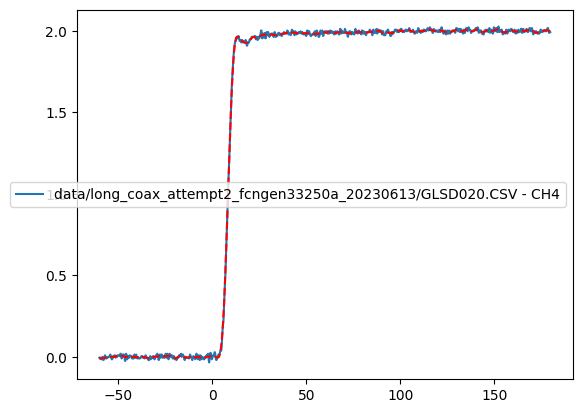

In [2]:
sys.argv[1]='data/long_coax_attempt2_fcngen33250a_20230613/GLSD020.CSV'; exec(open('make_pwl_file.py').read())

Copy [ltra_test.asc](ltra_test.asc) to [tdr_4ftucryomanginintwp_floatingshield_fcngen33250a.asc](tdr_4ftucryomanginintwp_floatingshield_fcngen33250a.asc).  Measured 88.9 Ohm roundtrip resistance for length of 48.5" = 1.232 meters.  Starting with this: 

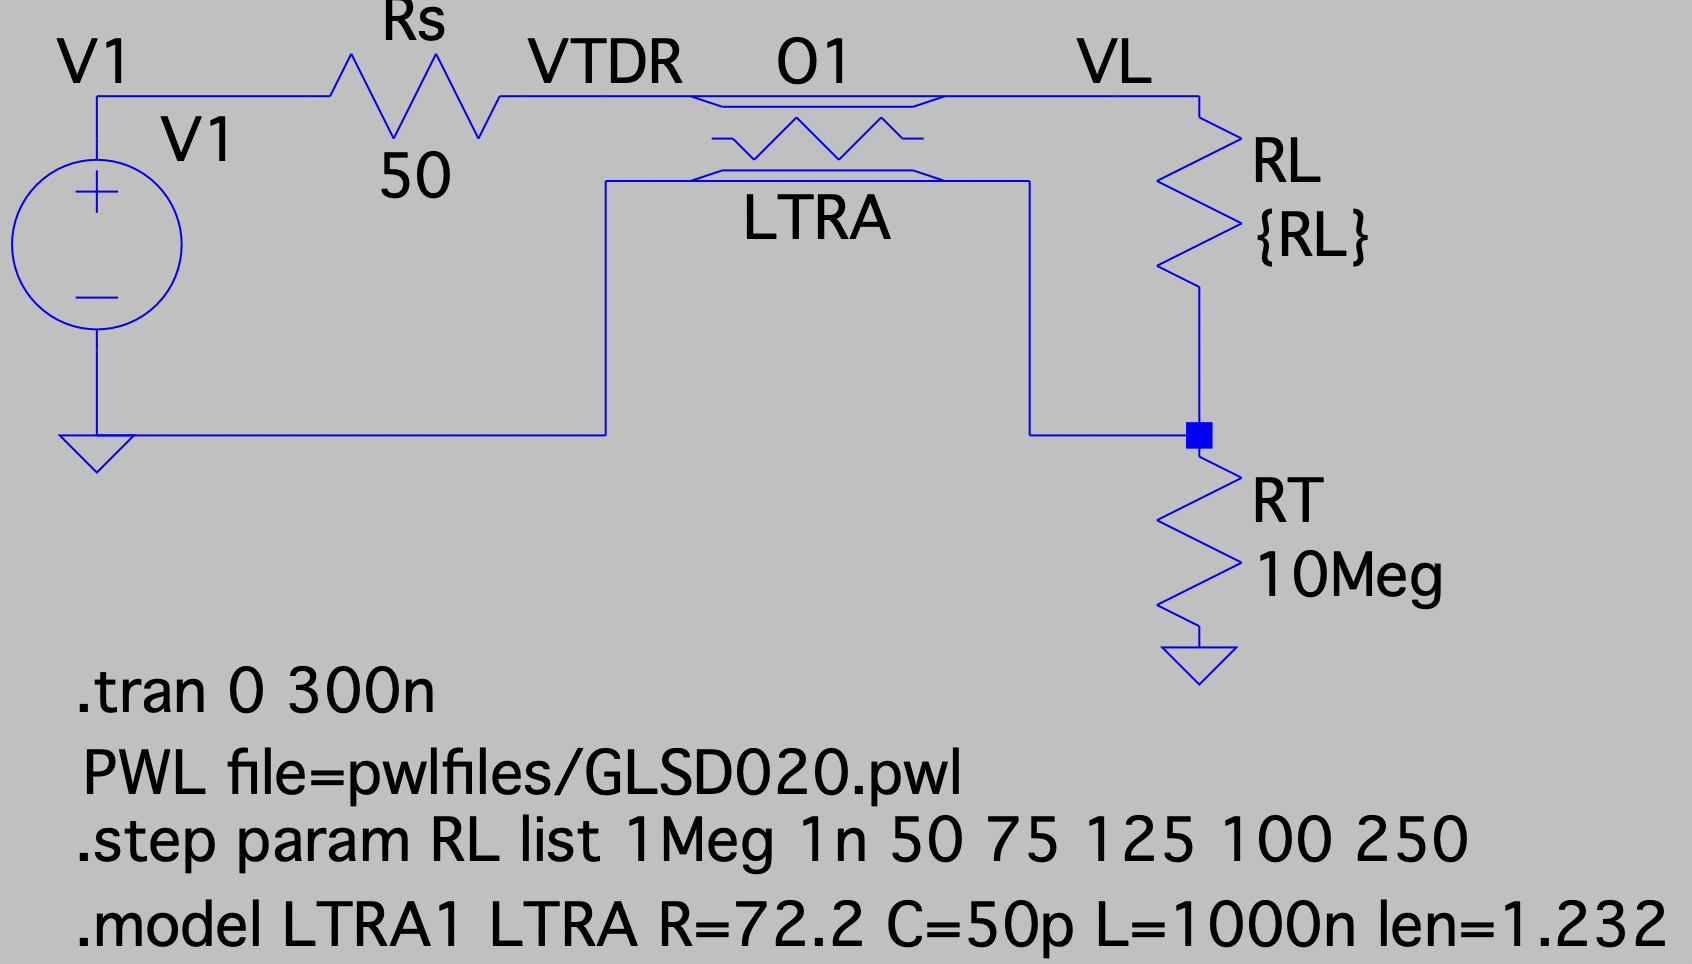

This will simulate the circuit shown for the listed RLs.  Had to add RT to get LTspice simulation to converge.

Really bad minimizer to try and find a close to optimal solution ; [sweep.py](sweep.py):

In [57]:
!cat sweep.py

import numpy as np
import os
#python3 -i lazy_ltspice_chi2.py 8.8 8 100 100

os.system('rm -v results.out')

R=72.2
for C in np.linspace(30,70,20):
    for L in np.linspace(500,1500,20):
        cmd=f'python3 lazy_ltspice_chi2.py {R:.3f} {C:.3f} {L:.3f} 1.232'
        print(cmd)
        os.system(cmd)


Found these minima;

In [59]:
!sort -k 5 results.out | head -n 20

72.200	59.474	868.421	1.232	10.032028464755614
72.200	63.684	605.263	1.232	10.05296245743077
72.200	59.474	605.263	1.232	10.093627528299708
72.200	57.368	868.421	1.232	10.115809443365787
72.200	55.263	657.895	1.232	10.169681643701406
72.200	67.895	657.895	1.232	10.222587546082883
72.200	61.579	868.421	1.232	10.294066439282497
72.200	65.789	815.789	1.232	10.297285866668581
72.200	53.158	763.158	1.232	10.33628396410341
72.200	67.895	763.158	1.232	10.376752140536153
72.200	65.789	605.263	1.232	10.501930843188855
72.200	53.158	710.526	1.232	10.582128472274016
72.200	55.263	868.421	1.232	10.587682530194945
72.200	57.368	605.263	1.232	10.617058737179505
72.200	53.158	815.789	1.232	10.659208706826968
72.200	63.684	868.421	1.232	10.888162897600969
72.200	70.000	710.526	1.232	11.143074768321492
72.200	67.895	605.263	1.232	11.254685670773485
72.200	70.000	657.895	1.232	11.312208830624652
72.200	53.158	657.895	1.232	11.40141513537112


What does the chisquared look like?

In [62]:
!mv results.out results_20230620.out

In [65]:
df=pd.read_csv("results_20230620.out", header=None, names=['R','C','L','len','chisq'],delimiter=r"\s+")

In [66]:
df.pivot

<bound method DataFrame.pivot of         R       C         L    len      chisq
0    72.2  30.000   500.000  1.232  52.780245
1    72.2  30.000   552.632  1.232  52.767348
2    72.2  30.000   605.263  1.232  52.784363
3    72.2  30.000   657.895  1.232  52.910395
4    72.2  30.000   710.526  1.232  53.093805
..    ...     ...       ...    ...        ...
398  72.2  70.000  1447.368  1.232  49.690936
399  72.2  70.000  1500.000  1.232  53.660757
400  72.2  59.474   868.421  1.232   8.519533
401  72.2  59.474   868.421  1.232   8.519533
402  72.2  59.474   868.421  1.232   8.519533

[403 rows x 5 columns]>

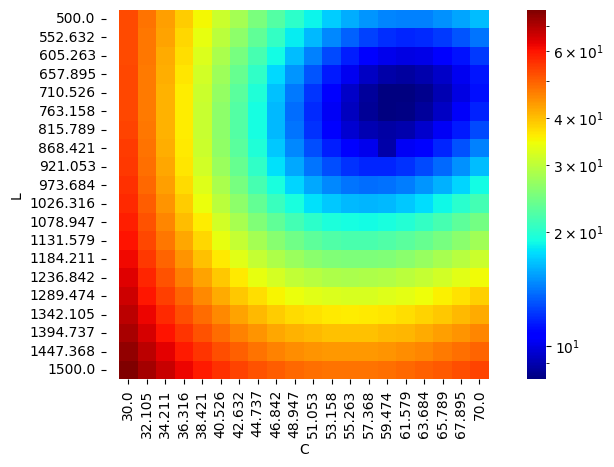

In [97]:
# Import seaborn
import seaborn as sns
from matplotlib.colors import LogNorm

hm = df.pivot_table(index='L', columns='C', values='chisq', aggfunc='mean')
plt.axis('equal')
sns.heatmap(hm, annot=False, fmt="g", cmap='jet', norm=LogNorm())

plt.gca().add_artist(plt.Circle((50,1000),100))

Eyeballing the minimum, looks like it's around L,C = 711 nH, 59.5 pF.  How does that compare to the data?

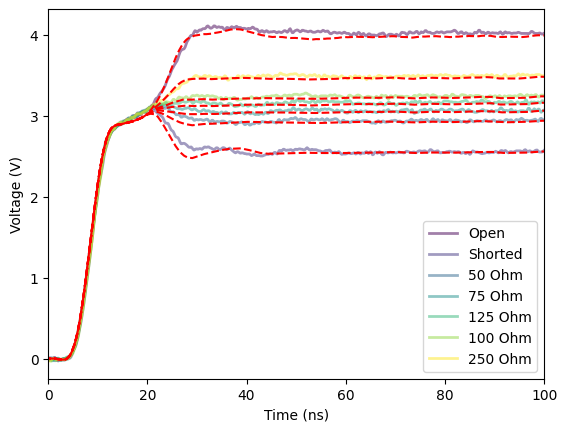

In [98]:
import ltspice

#
# Data
#
datafiles=['data/ucryo_magnanin_twp_floatingshield_try2_fcngen33250a_20230613/GLSD030.CSV',
           'data/ucryo_magnanin_twp_floatingshield_try2_fcngen33250a_20230613/GLSD031.CSV',
           'data/ucryo_magnanin_twp_floatingshield_try2_fcngen33250a_20230613/GLSD032.CSV',
           'data/ucryo_magnanin_twp_floatingshield_try2_fcngen33250a_20230613/GLSD033.CSV',
           'data/ucryo_magnanin_twp_floatingshield_try2_fcngen33250a_20230613/GLSD034.CSV',
           'data/ucryo_magnanin_twp_floatingshield_try2_fcngen33250a_20230613/GLSD035.CSV',
           'data/ucryo_magnanin_twp_floatingshield_try2_fcngen33250a_20230613/GLSD036.CSV']

# LTSpice trans data starts at zero, so pull the start time from the first dataset and use to offset the model data.
# assumes datasets were all taken with the same time offset.
datalabels=['Open',"Shorted","50 Ohm","75 Ohm","125 Ohm","100 Ohm","250 Ohm"]
mint,maxt=None,None

# Pick a nice color map
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.viridis(np.linspace(0,1,len(datafiles))))

# Load datasets, and plot.  Also extract time offset for model.
for datalabel,datafile in zip(datalabels,datafiles):
    datadf=pd.read_csv(datafile, index_col=False)
    datadf=datadf.dropna(axis=1,how='all')
    
    t_ns=1.e9*datadf['in s'].values
    v4=datadf['C4 in V'].values
    v4=v4-np.mean(v4[:200]) # shifts starting voltage to zero to simplify plots
    plt.plot(t_ns,v4,label=f'{datalabel}',alpha=0.5,lw=2) # plot with some transparency so can overlay model
    if mint is None:
        mint=np.min(t_ns)
        maxt=np.max(t_ns)

#
# Overplot model.  LTSpice must be open and sim must have been run.
#
ascpath = 'tdr_4ftucryomanginintwp_floatingshield_fcngen33250a.raw'
l = ltspice.Ltspice(ascpath)
l.parse() # Data loading sequence. It may take few minutes for huge file.

plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.viridis(np.linspace(0,1,len(datafiles))))

for i in range(l.case_count):
    time = l.get_time(i)    
    vtdr = l.get_data('V(vtdr)',i)
    plt.plot(mint+time*1.e9,2.0*vtdr,'r--') # 2x here because fcn gen outputs 2x the programmed signal in 50 Ohm mode

plt.xlabel('Time (ns)')
plt.xlim(mint,maxt)
plt.ylabel('Voltage (V)')

plt.legend()    
    
plt.xlabel('Time (ns)')
#plt.xlim(mint,maxt)
plt.xlim(0,100)
plt.ylabel('Voltage (V)')

plt.legend()

Not too bad.  Let's compare to VNA data with these parameters.